### In this part, we train approrpiately surrogates that are going to replace analytical functions which are important for describing the physics of the mean diesel engine system. In fact, these surrogates will be pre-trained NNs with the form of a classic FFNN. The target values $y$ for each pre-trained NN are calculated with labelled data according to empirical formulae. As long as the PINN model we are trying to construct does give random predictions for the state variable dynamics at the beginning of the training process, we will try to approximate the true values of the surrogates giving them noisy data as input. Consequently, we are interested in finding the maximum noise under which our surrogates predict the expected true outputs effectively.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate
from scipy.interpolate import interp1d

# Generated Clean Data

## Data from Simulink

### Dataset generated for Simulink model

In [3]:
# We import the whole dataset from Simulink
df = pd.read_excel(r"C:\Users\dimka\Documents\MyThesis\Initial Work\Diesel Engine - Clean Data.xlsx")
df = df.drop(df.index[1:9]).reset_index(drop=True) # false values generated from stimuling in small time points
df


,Time,BSR,eta_c,eta_tm,lambda,M_e,n_e,n_t,P_c,p_em,...,u_vgt,W_c,W_egr,W_ei,W_eo,W_f,W_t,x_r,u_egract,u_vgtact
0,0.000000,1.951041,0.200000,0.200000,0.009519,-171.342606,1500,49999.289307,261.261029,102371.759481,...,59.47,0.270270,0.003344,0.177690,0.185940,0.00825,0.020975,0.020222,80.000000,30.000000
1,0.021919,0.629172,0.200000,0.642131,0.309118,105.972246,1500,49342.660742,10013.924784,126779.641219,...,59.47,0.258459,0.043630,0.193252,0.201502,0.00825,0.096070,0.023646,80.000000,30.000000
2,0.031917,0.566922,0.332890,0.573281,0.427609,219.038720,1500,48877.589630,8115.513966,133496.117515,...,59.47,0.247234,0.049861,0.200068,0.208318,0.00825,0.109067,0.023678,80.000000,30.000000
3,0.034242,0.556992,0.356781,0.561252,0.453028,243.383424,1500,48793.370513,7949.438717,134851.260190,...,59.47,0.244505,0.051011,0.201531,0.209781,0.00825,0.111606,0.024454,80.000000,30.000000
4,0.036566,0.548066,0.378743,0.550193,0.477677,267.010109,1500,48715.151490,7816.974870,136142.945621,...,59.47,0.241737,0.052076,0.202947,0.211197,0.00825,0.113988,0.024625,80.000000,30.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,59.850723,0.587182,0.684212,0.595861,2.194658,786.711911,1500,63070.987184,15377.647697,170253.330355,...,52.61,0.251724,0.024811,0.275010,0.283260,0.00825,0.255270,0.027381,37.514234,53.723419
2196,59.867654,0.585477,0.684798,0.593906,2.195081,786.292749,1500,63075.022081,15366.473865,170778.771345,...,52.61,0.251345,0.025675,0.275194,0.283444,0.00825,0.254940,0.027432,37.490123,53.167830
2197,59.896336,0.583514,0.685764,0.591644,2.195681,785.818227,1500,63094.511457,15358.993178,171458.793513,...,52.61,0.250803,0.026647,0.275543,0.283793,0.00825,0.255338,0.027491,37.458454,52.774001
2198,59.936597,0.582434,0.686747,0.590391,2.196217,785.551042,1500,63146.575687,15379.378985,172004.701219,...,52.61,0.250469,0.027200,0.276007,0.284257,0.00825,0.256158,0.027565,37.442660,52.635209


### Constants

In [4]:
  #-------------   Table 7 --------------#
Ra = 287.0
Tim = 300.6186
Vim = 0.0220
Re = 286.0
Vem = 0.0200
Vd = 0.0127
ncyl = 6.0
gamma_a = 1.3964
cpa = 1011.0
cva = 724.0
rc = 17.0
xcv = 2.3371e-14
qHV = 42900000
dpipe = 0.1
lpipe = 1.0
npipe = 2.0
cpe = 1332.0
tegr1 = 0.05
tegr2 = 0.13
tdegr = 0.065
Kegr = 1.8
Pi_egropt = 0.6500
Jt = 2.0e-4
tvgt = 0.025
tdvgt = 0.04
cpe = 1332.0
gamma_e = 1.2734

Rt = 0.04
Rc = 0.0400
#----------   Table 9  -------------#
cvol1 = -2.0817e-4
cvol2 = -0.0034
cvol3 = 1.1497
cwpsi1 = 1.0882e-8
cwpsi2 = -1.7320e-4
cwpsi3 = 1.0286
pcopt = 1.0455
Wcopt = 0.2753
a1 = 3.0919
a2 = 2.1479
a3 = -2.4823
eta_cmax = 0.7364
cp = 0.2708
cegr1 = -1.1104e-4
cegr2 = 0.0178
cegr3 = 0.0
cwphi1 = -1.4298e-8
cwphi2 = -0.0015

cwphi3 = 29.6462
cm1 = 1.3563
cm2 = 2.7692e3
cm3 = 0.0100
BSRopt = 0.9755
eta_tm_max = 0.8180
cpsi2 = 0.0
cphi2 = 0.0
cvgt1 = 126.8719
cvgt2 = 117.1447
cf1 = 1.9480
cf2 = -0.7763
Kt = 2.8902

h_tm_max = 0.8180
#---------------True values of unknown parameters-----------------#
Aegrmax_true = 4.0e-4
eta_sc_true = 1.1015
htot_true = 96.2755
Avgtmax_true = 8.4558e-4
#---------------#
pi = np.pi
pamb = 1.0111e5
Tamb = 298.4636
#----Guesses----#
cpsi1 , cphi1 = 1.0, 1.0

## Numerically generated Data

### The stimulink model does not provide data for turbo speed $ω_{t}$, EGR1 valve position $\tilde{u}_{egr1}$ , EGR2 valve position $\tilde{u}_{egr2}$ and VGT actuator position $\tilde{u}_{vgt}$. These variables---or functions of those--- have to be used as input for the training of our surrogates. Data for these variables will be generated with the numerical solution of the ODE that describes the physics of each variable. We have to numerically generate data for training, validation and testing datasets.

#### Initial conditions

In [5]:
omegat0 = 5.236e3
u_egr10 = 18.2518
u_egr20 = 18.1813
u_vgt0 = 59.47

In [6]:
# we are going to solve the ODEs in the whole time domain (0,60s)
time = df['Time']
time = np.array(time)
time

array([0.00000000e+00, 2.19187518e-02, 3.19167751e-02, ...,
       5.98963357e+01, 5.99365975e+01, 6.00000000e+01], shape=(2200,))

#### Data needed for solving the ODEs

In [7]:
# Data for u_egr, u_vgt
uvgt_data = df['u_vgtact']
uegr_data = df['u_egract']

# Data for omegat
Pc_data = df['P_c']
eta_tm_data = df['eta_tm']
Wt_data = df['W_t']
Tem_data = df['T_em']
pem_data = df['p_em']



In [8]:
### We solve with numerical integration the ODes for u_egr1, u_egr2, u_vgt, omegat

##----- Defining the ODEs ------#

# ODE for u_vgt
uvgt_interp = interp1d(time, uvgt_data, kind='linear', fill_value="extrapolate")

def ODE_u_vgt(t,y):
    u_vgt = y
    uvgt_t = uvgt_interp(t)

    du_vgt_t = (1/tvgt) * (uvgt_t - u_vgt)

    return du_vgt_t


# ODE system for u_egr1, u_egr2
uegr_interp = interp1d(time, uegr_data, kind='linear', fill_value="extrapolate")

def ODE_system_u_egr1_u_egr2(t,y):
    u_egr1, u_egr2 = y
    uegr_interp_t = uegr_interp(t)

    du_egr1_t = (1/tegr1) * (uegr_interp_t - u_egr1)
    du_egr2_t = (1/tegr2) * (uegr_interp_t - u_egr2)

    return du_egr1_t, du_egr2_t


# ODE for omegat
Pc_interp = interp1d(time, Pc_data, kind='linear', fill_value="extrapolate")

Pi_t = pamb/pem_data
Pt_eta_m = eta_tm_data * Wt_data * cpe * Tem_data * (1 - (Pi_t)**(1-1/gamma_e))
Pt_eta_m_interp = interp1d(time, Pt_eta_m, kind='linear', fill_value="extrapolate")

def ODE_omegat(t,y):
    omegat = y
    Pc_t = Pc_interp(t)
    Pt_eta_m_t = Pt_eta_m_interp(t)

    domegat_t = (Pt_eta_m_t - Pc_t)/(Jt * omegat)

    return domegat_t


In [9]:
len(Pt_eta_m)

2200

In [10]:
len(time)

2200

In [11]:
# Generating Data for the variables

def gen_data_u_vgt():
    t = time
    sol = integrate.solve_ivp(ODE_u_vgt, (0,60), [u_vgt0], method='RK45', t_eval=t)
    u_vgt_data = sol.y[0]

    return u_vgt_data

def gen_data_u_egr1_u_egr2():
    t = time
    u_egr120 = [u_egr10, u_egr20]
    sol = integrate.solve_ivp(ODE_system_u_egr1_u_egr2, (0,60), u_egr120, method='RK45', t_eval=t)
    u_egr1_data = sol.y[0]
    u_egr2_data = sol.y[1]

    return u_egr1_data, u_egr2_data


def gen_data_omegat():
    t = time
    sol = integrate.solve_ivp(ODE_omegat, (0,60), [omegat0], method='RK45', t_eval=t)
    omegat_data = sol.y[0]

    return omegat_data

In [12]:
# Data for u_vgt
u_vgt_data = gen_data_u_vgt()

# Data for u_egr1, u_egr2
u_egr1_data, u_egr2_data = gen_data_u_egr1_u_egr2()

# Data for omegat
omegat_data = gen_data_omegat()



In [13]:
# Data for a variable u_egr
u_egr_data = Kegr * u_egr1_data - (Kegr - 1) * u_egr2_data

## Whole Dataset

In [14]:
# We insert the numerically generated data to the initial Simulink dataset
df['u_egr1'] = u_egr1_data
df['u_egr2'] = u_egr2_data
df['u_vgt'] = u_vgt_data
df['omegat'] = omegat_data
df['u_egr'] = u_egr_data


In [15]:
# Whole Dataset : Simulink Data + Numerically Generated Data
df_generated = df
df_generated

,Time,BSR,eta_c,eta_tm,lambda,M_e,n_e,n_t,P_c,p_em,...,W_ei,W_eo,W_f,W_t,x_r,u_egract,u_vgtact,u_egr1,u_egr2,omegat
0,0.000000,1.951041,0.200000,0.200000,0.009519,-171.342606,1500,49999.289307,261.261029,102371.759481,...,0.177690,0.185940,0.00825,0.020975,0.020222,80.000000,30.000000,18.251800,18.181300,5236.000000
1,0.021919,0.629172,0.200000,0.642131,0.309118,105.972246,1500,49342.660742,10013.924784,126779.641219,...,0.193252,0.201502,0.00825,0.096070,0.023646,80.000000,30.000000,40.168104,27.772979,5173.721536
2,0.031917,0.566922,0.332890,0.573281,0.427609,219.038720,1500,48877.589630,8115.513966,133496.117515,...,0.200068,0.208318,0.00825,0.109067,0.023678,80.000000,30.000000,47.398776,31.639157,5128.478697
3,0.034242,0.556992,0.356781,0.561252,0.453028,243.383424,1500,48793.370513,7949.438717,134851.260190,...,0.201531,0.209781,0.00825,0.111606,0.024454,80.000000,30.000000,48.882490,32.496330,5118.098000
4,0.036566,0.548066,0.378743,0.550193,0.477677,267.010109,1500,48715.151490,7816.974870,136142.945621,...,0.202947,0.211197,0.00825,0.113988,0.024625,80.000000,30.000000,50.298104,33.338305,5107.971076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,59.850723,0.587182,0.684212,0.595861,2.194658,786.711911,1500,63070.987184,15377.647697,170253.330355,...,0.275010,0.283260,0.00825,0.255270,0.027381,37.514234,53.723419,37.550593,37.567470,6964.706525
2196,59.867654,0.585477,0.684798,0.593906,2.195081,786.292749,1500,63075.022081,15366.473865,170778.771345,...,0.275194,0.283444,0.00825,0.254940,0.027432,37.490123,53.167830,37.539053,37.559360,6965.884225
2197,59.896336,0.583514,0.685764,0.591644,2.195681,785.818227,1500,63094.511457,15358.993178,171458.793513,...,0.275543,0.283793,0.00825,0.255338,0.027491,37.458454,52.774001,37.516281,37.542298,6968.322029
2198,59.936597,0.582434,0.686747,0.590391,2.196217,785.551042,1500,63146.575687,15379.378985,172004.701219,...,0.276007,0.284257,0.00825,0.256158,0.027565,37.442660,52.635209,37.482090,37.517548,6972.757291


In [16]:
# Saving the Dataset
#df_generated.to_excel('Generated Data.xlsx', index = False)

# Clean Data for Empirical Formulae

## Variables used for calculations of empirical formulae

In [17]:
# Data directly extracted from our generated data frame
Wei_data = df_generated['W_ei']
Wegr_data = df_generated['W_egr']
Wc_data = df_generated['W_c']
Wt_data = df_generated['W_t']
Tem_data = df_generated['T_em']
Tc_data = df_generated['T_c']
pim_data = df_generated['p_im']
pem_data = df_generated['p_em']
ne_data = df_generated['n_e']
omegat_data = df_generated['omegat']

In [18]:
##-----Functions for empirical formulae------##

# Pi_egr
def Pi_egr(pim: np.ndarray, pem: np.ndarray):
    pegr_values = []
    for i in range(len(pim)):
        ratio = pim[i]/pem[i]
        if ratio < Pi_egropt:
            pegr_values.append(Pi_egropt)
        elif ratio > 1:
            pegr_values.append(1)
        else:
            pegr_values.append(ratio)
    return np.array(pegr_values)

pegr_data = Pi_egr(pim_data, pem_data)
Psi_egr_data = (1-((1-pegr_data)/(1-Pi_egropt) -1)**2)

# Pt_eta_m
domegat_t = np.gradient(omegat_data, time)
Pt_eta_m = Pc_data + Jt * omegat_data * domegat_t

# Pi_t
Pi_t = pamb/pem_data

# Pi_c 
Pi_c = pim_data/pamb


## Calculating empirical formulae

In [19]:
# eta_vol
eta_vol_emp = (120 * Wei_data * Ra *Tim)/(pim_data * ne_data * Vd)

# fegr
fegr_emp = Wegr_data * np.sqrt(Tem_data * Re)/(Aegrmax_true * pim_data * Psi_egr_data)

# F_vgt_Pi_t
F_vgt_Pi_t_emp = Wt_data * np.sqrt(Tem_data * Re)/(Avgtmax_true * pem_data)

# eta_tm 
eta_tm_emp = Pt_eta_m/(Wt_data * cpe * Tem_data * (1 - Pi_t**(1 - 1/gamma_e)))

# eta_c
eta_c_emp = (Tamb * (Pi_c**(1 - 1/gamma_a) -1))/(Tc_data - Tamb)

# Phi_c
Phi_c_emp = Ra * Tamb * Wc_data/(pamb * pi * omegat_data * (Rc**3))

In [20]:
# Creating a DataFrame for empirical formulae

# Target values
df_empirical = pd.DataFrame(time, columns=['Time'])
df_empirical['eta_vol_emp'] = eta_vol_emp
df_empirical['fegr_emp'] = fegr_emp
df_empirical['F_vgt_Pi_t_emp'] = F_vgt_Pi_t_emp
df_empirical['eta_tm_emp'] = eta_tm_emp
df_empirical['eta_c_emp'] = eta_c_emp
df_empirical['Phi_c_emp'] = Phi_c_emp

df_empirical['eta_tm_emp'].iloc[0] = df_empirical['eta_tm_emp'].iloc[1]
df_empirical['eta_c_emp'].iloc[0] = df_empirical['eta_c_emp'].iloc[1]

# Input variables
df_empirical['pim'] = pim_data
df_empirical['pem'] = pem_data
df_empirical['omegat'] = omegat_data
df_empirical['u_vgt'] = u_vgt_data
df_empirical['u_egr'] = u_egr_data
df_empirical['ne'] = ne_data
df_empirical['Wei'] = Wei_data
df_empirical['Wegr'] = Wegr_data
df_empirical['Tem'] = Tem_data
df_empirical['Wt'] = Wt_data
df_empirical['Wc'] = Wc_data
df_empirical['Tc'] = Tc_data


df_empirical


C:\Users\dimka\AppData\Local\Temp\ipykernel_12952\3541844907.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_empirical['eta_tm_emp'].iloc[0] = df_empirical['eta_tm_emp'].iloc[1]
C:\Users\dimka\AppData\Local\Temp\ipykernel_12952\35418

,Time,eta_vol_emp,fegr_emp,F_vgt_Pi_t_emp,eta_tm_emp,eta_c_emp,Phi_c_emp,pim,pem,omegat,u_vgt,u_egr,ne,Wei,Wegr,Tem,Wt,Wc,Tc
0,0.000000,0.952944,0.719035,0.119919,1.133810,0.200027,0.217494,101339.735203,102371.759481,5236.000000,59.470000,18.308200,1500,0.177690,0.003344,856.396676,0.020975,0.270270,299.419771
1,0.021919,0.949986,0.816219,0.442985,1.133810,0.200027,0.210493,110558.295191,126779.641219,5173.721536,42.271633,50.084203,1500,0.193252,0.043630,854.370456,0.096070,0.258459,336.786809
2,0.031917,0.948725,0.829078,0.475086,0.495480,0.332920,0.203127,114609.765503,133496.117515,5128.478697,38.177619,60.006470,1500,0.200068,0.049861,845.345229,0.109067,0.247234,330.931762
3,0.034242,0.948457,0.831178,0.480599,0.457124,0.356811,0.201293,115480.623215,134851.260190,5118.098000,37.440175,61.991419,1500,0.201531,0.051011,843.031519,0.111606,0.244505,330.622310
4,0.036566,0.948199,0.833060,0.485602,0.435733,0.378773,0.199408,116323.406454,136142.945621,5107.971076,36.813493,63.865944,1500,0.202947,0.052076,840.962862,0.113988,0.241737,330.448542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,59.850723,0.935973,0.544557,0.803468,0.598633,0.684221,0.152290,159686.621004,170253.330355,6964.706525,54.880088,37.537091,1500,0.275010,0.024811,717.912210,0.255270,0.251724,358.888226
2196,59.867654,0.935944,0.545611,0.800108,0.596025,0.684807,0.152035,159798.613166,170778.771345,6965.884225,54.198470,37.522807,1500,0.275194,0.025675,718.179396,0.254940,0.251345,358.935341
2197,59.896336,0.935888,0.546737,0.798258,0.591538,0.685773,0.151654,160010.580351,171458.793513,6968.322029,53.282042,37.495468,1500,0.275543,0.026647,718.321398,0.255338,0.250803,359.036642
2198,59.936597,0.935815,0.547352,0.798157,0.588911,0.686756,0.151356,160292.944131,172004.701219,6972.757291,52.784553,37.453723,1500,0.276007,0.027200,718.099692,0.256158,0.250469,359.197846


## Analytical functions for empirical formulae

In [21]:
# eta_vol analytical
eta_vol_analytical = cvol1 * np.sqrt(pim_data) + cvol2 * np.sqrt(ne_data) + cvol3


# fegr analytical
def fegr(u_egr):
    fegr_values = []
    for u_egr_i in u_egr:
        if (u_egr_i <= ( -cegr2/(2 * cegr1))):
            fegr_values.append((cegr1 * (u_egr_i**2) + cegr2 * u_egr_i + cegr3))
        else :
           fegr_values.append(cegr3 - (cegr2**2)/(4 * cegr1))
    return np.array(fegr_values)

fegr_analytical = fegr(u_egr_data)


# F_vgt_Pi_t_analytical
def fvgt_Pit(u_vgt : np.ndarray, pem: np.ndarray):
  f_vgt_values = []
  f_pit_values = []

  for i in range(len(u_vgt)):
      f_vgt_values.append(cf2 + cf1 * np.sqrt(np.maximum(0, 1 - ((u_vgt[i] - cvgt2)/cvgt1)**2)))
      f_pit_values.append(np.sqrt(1 - (pamb/pem[i])**Kt))

  fvgt_Pit_values = np.array(f_vgt_values) * np.array(f_pit_values)
  return fvgt_Pit_values

fvgt_Pit_analytical = fvgt_Pit(u_vgt_data, pem_data)


# eta_tm_analytical
def eta_tm(BSR :np.ndarray, omegat: np.ndarray):
    cm = cm1 * ((np.maximum(0, omegat - cm2))**cm3)
    h_tm_values = h_tm_max - cm * ((BSR - BSRopt)**2)
    return h_tm_values

BSR = (Rt * omegat_data)/np.sqrt(2 * cpe * Tem_data * (1 - ((pamb/pem_data)**(1 - 1/gamma_e))))

eta_tm_analytical = eta_tm(BSR, omegat_data)

## eta_c_analytical
pi_c = (Pi_c - 1) ** cp

# X matric
X = np.vstack([
    Wc_data - Wcopt,
    pi_c - pcopt
])  # shape: (2, N)

# Q_c matrix
Q_c = np.array([
    [a1, a3],
    [a3, a2]
])

# Quadratic form for each time step
QX = Q_c @ X  # (2, N)
quad_form = np.einsum('ij,ij->j', X, QX)  # (N,)

eta_c_analytical = eta_cmax - quad_form

# Phi_c 
def cpsi1_func(omegat: np.ndarray):
    return cwpsi1 * omegat**2 + cwpsi2 * omegat + cwpsi3

def cphi1_func(omegat: np.ndarray):
    return cwphi1 * omegat**2 + cwphi2 * omegat + cwphi3

cpsi1_vals = cpsi1_func(omegat_data)
cphi1_vals = cphi1_func(omegat_data)

Psi_c = 2 * cpa * Tamb * (((pim_data / pamb) ** (1 - 1 / gamma_a)) - 1) / (Rc ** 2 * omegat_data ** 2)

Phi_c_analytical = np.sqrt(
    np.maximum(0, (1 - cpsi1_vals * (Psi_c - cpsi2) ** 2) / cphi1_vals)
) + cphi2


In [26]:
print(omegat_data)

0       5236.000000
1       5173.721536
2       5128.478697
3       5118.098000
4       5107.971076
           ...     
2195    6964.706525
2196    6965.884225
2197    6968.322029
2198    6972.757291
2199    6982.422156
Name: omegat, Length: 2200, dtype: float64


In [22]:
Phi_c_analytical

0       0.216164
1       0.209580
2       0.202514
3       0.200613
4       0.198635
          ...   
2195    0.179121
2196    0.178975
2197    0.178711
2198    0.178414
2199    0.178209
Length: 2200, dtype: float64

# Datasets

## Empirical Formulae Datasets

### Preprocessing

In [21]:
# Parameters
total_rows = len(df_empirical)
train_ratio = 0.75
val_ratio = 0.10
test_ratio = 0.15

# Times to exclude from testing
times_to_exclude = set(np.round(np.arange(0, 60.01, 0.2), 8))

# Adding rounded time column for safer comparison
df_empirical['Time_rounded'] = df_empirical['Time'].round(8)

# Creating bins for time domain - tune bin width for granularity
bin_width = 5  # e.g., 5 units of time per bin, adjust as needed
time_min = df_empirical['Time'].min()
time_max = df_empirical['Time'].max()
bins = np.arange(time_min, time_max + bin_width, bin_width)

# Assigning each row to a time bin
df_empirical['time_bin'] = pd.cut(df_empirical['Time'], bins=bins, include_lowest=True)

# Preparing empty lists for split pieces
train_list = []
val_list = []
test_list = []

# Processing each bin separately
for b in df_empirical['time_bin'].unique():

    bin_rows = df_empirical[df_empirical['time_bin'] == b]

    # Among bin_rows, we separate test-eligible and test-ineligible for testing split
    test_eligible = bin_rows[~bin_rows['Time_rounded'].isin(times_to_exclude)]
    test_ineligible = bin_rows[bin_rows['Time_rounded'].isin(times_to_exclude)]

    n_bin = len(bin_rows)
    n_train_bin = int(train_ratio * n_bin)
    n_val_bin = int(val_ratio * n_bin)
    n_test_bin = n_bin - n_train_bin - n_val_bin

    # we make sure we don't pick more test samples than eligible
    n_test_bin = min(n_test_bin, len(test_eligible))

    # we sample test from test_eligible
    test_sample = test_eligible.sample(n=n_test_bin, random_state=42) if n_test_bin > 0 else pd.DataFrame(columns=df_empirical.columns)

    # Removing test_sample from bin_rows to get remaining for train+val
    remaining = bin_rows.drop(test_sample.index)

    # Now we sample val from remaining
    n_val_bin = min(n_val_bin, len(remaining))  # in case fewer rows left
    val_sample = remaining.sample(n=n_val_bin, random_state=42) if n_val_bin > 0 else pd.DataFrame(columns=df_empirical.columns)

    # Training sample is the rest
    train_sample = remaining.drop(val_sample.index)

    # we append to to lists
    train_list.append(train_sample)
    val_list.append(val_sample)
    test_list.append(test_sample)

# Concatenating all bins
df_empirical_training = pd.concat(train_list).sort_values(by='Time').reset_index(drop=True)
df_empirical_validation = pd.concat(val_list).sort_values(by='Time').reset_index(drop=True)
df_empirical_testing = pd.concat(test_list).sort_values(by='Time').reset_index(drop=True)

# Droping helper columns
df_empirical_training = df_empirical_training.drop(columns=['Time_rounded', 'time_bin'])
df_empirical_validation = df_empirical_validation.drop(columns=['Time_rounded', 'time_bin'])
df_empirical_testing = df_empirical_testing.drop(columns=['Time_rounded', 'time_bin'])

# Datasets sizes
print(f"Training size: {len(df_empirical_training)}")
print(f"Validation size: {len(df_empirical_validation)}")
print(f"Testing size: {len(df_empirical_testing)}")


Training size: 1646
Validation size: 215
Testing size: 339


### Training

In [22]:
df_empirical_training

,Time,eta_vol_emp,fegr_emp,F_vgt_Pi_t_emp,eta_tm_emp,eta_c_emp,Phi_c_emp,pim,pem,omegat,u_vgt,u_egr,ne,Wei,Wegr,Tem,Wt,Wc,Tc
0,0.000000,0.952944,0.719035,0.119919,1.133810,0.200027,0.217494,101339.735203,102371.759481,5236.000000,59.470000,18.308200,1500,0.177690,0.003344,856.396676,0.020975,0.270270,299.419771
1,0.021919,0.949986,0.816219,0.442985,1.133810,0.200027,0.210493,110558.295191,126779.641219,5173.721536,42.271633,50.084203,1500,0.193252,0.043630,854.370456,0.096070,0.258459,336.786809
2,0.031917,0.948725,0.829078,0.475086,0.495480,0.332920,0.203127,114609.765503,133496.117515,5128.478697,38.177619,60.006470,1500,0.200068,0.049861,845.345229,0.109067,0.247234,330.931762
3,0.034242,0.948457,0.831178,0.480599,0.457124,0.356811,0.201293,115480.623215,134851.260190,5118.098000,37.440175,61.991419,1500,0.201531,0.051011,843.031519,0.111606,0.244505,330.622310
4,0.036566,0.948199,0.833060,0.485602,0.435733,0.378773,0.199408,116323.406454,136142.945621,5107.971076,36.813493,63.865944,1500,0.202947,0.052076,840.962862,0.113988,0.241737,330.448542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,59.833792,0.935996,0.543484,0.811249,0.597175,0.683788,0.152468,159598.233388,169794.234310,6963.712033,55.500647,37.519304,1500,0.274864,0.024024,717.656779,0.257093,0.251982,358.848409
1642,59.850723,0.935973,0.544557,0.803468,0.598633,0.684221,0.152290,159686.621004,170253.330355,6964.706525,54.880088,37.537091,1500,0.275010,0.024811,717.912210,0.255270,0.251724,358.888226
1643,59.867654,0.935944,0.545611,0.800108,0.596025,0.684807,0.152035,159798.613166,170778.771345,6965.884225,54.198470,37.522807,1500,0.275194,0.025675,718.179396,0.254940,0.251345,358.935341
1644,59.936597,0.935815,0.547352,0.798157,0.588911,0.686756,0.151356,160292.944131,172004.701219,6972.757291,52.784553,37.453723,1500,0.276007,0.027200,718.099692,0.256158,0.250469,359.197846


### Validation

In [23]:
df_empirical_validation

,Time,eta_vol_emp,fegr_emp,F_vgt_Pi_t_emp,eta_tm_emp,eta_c_emp,Phi_c_emp,pim,pem,omegat,u_vgt,u_egr,ne,Wei,Wegr,Tem,Wt,Wc,Tc
0,0.103729,0.944762,0.694572,0.748722,0.516947,0.596014,0.162223,127820.450948,143132.303432,5042.452359,51.722935,74.133461,1500,0.222197,0.038486,798.444663,0.189630,0.194136,332.920708
1,0.117331,0.944633,0.653218,0.756680,0.527517,0.600842,0.160910,128262.212490,143517.708081,5051.966298,54.259202,68.057169,1500,0.222935,0.036161,797.062627,0.192328,0.192928,333.164054
2,0.129919,0.944560,0.623271,0.761659,0.509331,0.602852,0.160488,128513.030989,143904.007947,5062.135425,55.926929,62.395874,1500,0.223353,0.034757,796.524876,0.194180,0.192809,333.342200
3,0.166728,0.944422,0.574175,0.769687,0.508408,0.604529,0.160662,128985.891960,144883.593978,5095.955373,58.386733,48.566489,1500,0.224143,0.032828,795.976781,0.197631,0.194308,333.796756
4,0.468228,0.942939,0.678487,0.755756,0.524034,0.631749,0.156977,134140.174903,149096.564710,5358.104804,55.378371,48.879440,1500,0.232733,0.037833,780.747159,0.201635,0.199617,337.936704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,58.247508,0.936361,0.558151,0.878025,0.625829,0.674182,0.155130,158204.346354,163107.280001,7036.455015,67.245602,40.723897,1500,0.272570,0.012849,714.008976,0.267979,0.259060,358.455431
211,58.600000,0.936533,0.548588,0.873847,0.624629,0.673654,0.154538,157549.261503,162939.849985,7016.995057,66.610421,39.438217,1500,0.271491,0.013762,715.840638,0.266089,0.257357,357.910268
212,58.800000,0.936579,0.544834,0.869499,0.620662,0.673896,0.154100,157375.799041,163152.386842,7012.016715,65.754806,38.974356,1500,0.271205,0.014552,716.639715,0.264962,0.256447,357.731835
213,58.800899,0.936579,0.544908,0.869680,0.620247,0.673905,0.154093,157375.082227,163171.952332,7011.990676,65.751940,38.974889,1500,0.271204,0.014600,716.669818,0.265043,0.256433,357.730378


### Testing

In [24]:
df_empirical_testing

,Time,eta_vol_emp,fegr_emp,F_vgt_Pi_t_emp,eta_tm_emp,eta_c_emp,Phi_c_emp,pim,pem,omegat,u_vgt,u_egr,ne,Wei,Wegr,Tem,Wt,Wc,Tc
0,0.039922,0.947843,0.835479,0.492067,0.419659,0.407497,0.196607,117489.441325,137906.938291,5093.962782,36.133288,66.387470,1500,0.204904,0.053500,838.036741,0.117206,0.237687,330.355010
1,0.044152,0.947423,0.836521,0.546308,0.386903,0.439187,0.193028,118869.825864,139701.326352,5077.629516,35.702814,69.276000,1500,0.207220,0.054602,834.291791,0.132115,0.232612,330.409180
2,0.065197,0.945872,0.817996,0.685481,0.454837,0.539413,0.176970,124047.375259,142557.559174,5027.129913,40.097561,79.738276,1500,0.215892,0.050828,814.297496,0.171224,0.211140,331.527535
3,0.065728,0.945844,0.817385,0.687293,0.458090,0.541020,0.176627,124142.622617,142569.906169,5026.591967,40.279797,79.912404,1500,0.216051,0.050663,813.880625,0.171736,0.210708,331.556720
4,0.078483,0.945298,0.785174,0.719297,0.519406,0.570616,0.169545,125992.084102,142702.822503,5023.507916,44.682776,81.372587,1500,0.219143,0.045926,805.943284,0.180784,0.202136,332.172657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,59.422954,0.936422,0.539780,0.840916,0.604373,0.677837,0.153304,157970.917138,165816.567504,6975.436775,60.812542,37.812005,1500,0.272185,0.018975,717.995573,0.260191,0.253791,357.922481
335,59.451703,0.936400,0.540218,0.834984,0.603405,0.678340,0.153156,158055.881609,166272.198675,6973.354350,59.935085,37.798920,1500,0.272325,0.019776,718.267243,0.259016,0.253470,357.954575
336,59.601319,0.936267,0.540415,0.833821,0.596663,0.680199,0.153038,158563.258860,167313.380858,6964.332190,58.741044,37.562950,1500,0.273161,0.020916,717.939192,0.260334,0.252947,358.245421
337,59.709139,0.936135,0.542785,0.817771,0.592369,0.682483,0.152415,159065.378447,169031.864928,6961.233149,56.163335,37.520144,1500,0.273987,0.023508,718.412659,0.257861,0.251805,358.491509


### Saving Datasets


In [25]:
df_empirical.to_excel('Empirical Formulae Data.xlsx', index=False)
df_empirical_training.to_excel("Empirical Formulae Training Data.xlsx", index = False)
df_empirical_validation.to_excel("Empirical Formulae Validation Data.xlsx", index = False)
df_empirical_testing.to_excel("Empirical Formulae Testing Data.xlsx", index = False)

## PINNs Model Dataset

### Whole Dataset

In [26]:
df_pinns = pd.DataFrame(time, columns=['Time'])
df_pinns['pim'] = pim_data
df_pinns['pem'] = pem_data
df_pinns['omegat'] = omegat_data
df_pinns['u_egr1'] = u_egr1_data
df_pinns['u_egr2'] = u_egr2_data
df_pinns['u_vgt'] = u_vgt_data
df_pinns['xr'] = df['x_r']
df_pinns['T1'] = df['T_1']
df_pinns['uvgt'] = uvgt_data
df_pinns['uegr'] = uegr_data

df_pinns


,Time,pim,pem,omegat,u_egr1,u_egr2,u_vgt,xr,T1,uvgt,uegr
0,0.000000,101339.735203,102371.759481,5236.000000,18.251800,18.181300,59.470000,0.020222,314.948446,30.000000,80.000000
1,0.021919,110558.295191,126779.641219,5173.721536,40.168104,27.772979,42.271633,0.023646,317.040796,30.000000,80.000000
2,0.031917,114609.765503,133496.117515,5128.478697,47.398776,31.639157,38.177619,0.023678,317.057631,30.000000,80.000000
3,0.034242,115480.623215,134851.260190,5118.098000,48.882490,32.496330,37.440175,0.024454,317.196772,30.000000,80.000000
4,0.036566,116323.406454,136142.945621,5107.971076,50.298104,33.338305,36.813493,0.024625,317.216516,30.000000,80.000000
...,...,...,...,...,...,...,...,...,...,...,...
2195,59.850723,159686.621004,170253.330355,6964.706525,37.550593,37.567470,54.880088,0.027381,314.034593,53.723419,37.514234
2196,59.867654,159798.613166,170778.771345,6965.884225,37.539053,37.559360,54.198470,0.027432,314.066629,53.167830,37.490123
2197,59.896336,160010.580351,171458.793513,6968.322029,37.516281,37.542298,53.282042,0.027491,314.102795,52.774001,37.458454
2198,59.936597,160292.944131,172004.701219,6972.757291,37.482090,37.517548,52.784553,0.027565,314.140840,52.635209,37.442660


### Training Dataset

In [27]:
# Creating the time grid: 0, 0.2, 0.4, ..., 60
time_grid = np.round(np.arange(0, 60.01, 0.2),4)  # 60.01 to include 60 with floating point tolerance

# Select training rows
df_pinns_training = df_pinns[df_pinns['Time'].isin(time_grid)]

df_pinns_training

,Time,pim,pem,omegat,u_egr1,u_egr2,u_vgt,xr,T1,uvgt,uegr
0,0.0,101339.735203,102371.759481,5236.000000,18.251800,18.181300,59.470000,0.020222,314.948446,30.000000,80.000000
35,0.2,129406.800173,145480.184436,5128.056881,42.115780,43.563471,59.125848,0.025505,315.967431,59.423034,36.363390
45,0.4,132992.294094,147870.631151,5304.617560,44.467344,42.967970,56.931849,0.025668,315.738014,56.870795,46.328794
55,0.6,136249.247682,150674.306689,5458.407463,52.180528,49.635682,54.550583,0.025882,315.496025,54.490125,52.874548
65,0.8,139291.293124,153666.740694,5604.432684,56.965506,55.006064,52.344610,0.026142,315.342781,52.339988,57.361389
...,...,...,...,...,...,...,...,...,...,...,...
2167,59.2,157540.208282,164438.086317,6992.112413,38.260234,38.460447,63.015550,0.026804,313.781069,63.000393,38.238529
2175,59.4,157926.682942,165627.829010,6977.141094,37.942042,38.092176,61.130140,0.026924,313.848559,61.049009,37.912594
2183,59.6,158559.684161,167285.800661,6964.392142,37.662771,37.787454,58.743628,0.027095,313.932024,58.678637,37.662170
2192,59.8,159465.428350,169505.762559,6962.240954,37.512368,37.590277,55.918985,0.027342,314.030687,55.870235,37.516093


### Validation Dataset

In [28]:
# Candidates for validation: rows NOT in training
df_candidates = df_pinns[~df_pinns.index.isin(df_pinns_training.index)]

# Size = 20% of training
validation_size = int(0.2 * len(df_pinns_training))

# Randomly sampling from remaining rows
df_pinns_validation = df_candidates.sample(n=validation_size, random_state=42)

# Sorted by time
df_pinns_validation = df_pinns_validation.sort_values(by='Time').reset_index(drop=True)

df_pinns_validation

,Time,pim,pem,omegat,u_egr1,u_egr2,u_vgt,xr,T1,uvgt,uegr
0,1.000246,142210.082362,156724.836476,5737.657119,60.794515,59.205059,50.412811,0.026466,315.167999,50.429164,61.060889
1,1.801579,152679.850632,168306.434089,6167.544631,71.336017,70.464860,44.634583,0.027490,314.843698,44.628953,71.524361
2,2.228022,157345.362586,173532.453286,6322.296201,74.475081,73.946920,42.667657,0.027913,314.723358,42.601273,74.531137
3,2.871939,163095.748400,179876.486075,6534.919577,76.904966,76.727280,41.010228,0.028425,314.548107,40.883633,76.954424
4,3.069592,164530.966877,181327.545672,6588.003575,77.077803,77.029501,40.730555,0.028554,314.489968,40.672638,77.124945
5,5.200927,171409.240515,185461.876316,6889.395597,69.774830,70.162080,43.375574,0.028756,313.987109,43.337993,69.700559
6,6.000485,171194.603805,183837.505987,6920.131944,65.689654,66.074539,45.456151,0.028577,313.869848,45.442766,65.649559
7,7.020958,170132.338969,181483.893448,6917.528820,62.548975,62.709399,47.749382,0.028344,313.787026,47.805266,62.543093
8,7.204647,169911.088141,181089.748393,6914.021504,62.302189,62.385238,48.033149,0.028305,313.778150,48.045755,62.238354
9,9.620452,167925.418293,178688.929712,6862.201867,55.988331,56.399795,49.679849,0.028107,313.808051,49.671133,55.973755


### Testing Dataset

In [29]:
# Used indices: training + validation
used_indices = df_pinns_training.index.union(df_pinns_validation.index)

# Testing = remaining rows
df_pinns_testing = df_pinns.drop(used_indices)

# Sorted by time
df_pinns_testing = df_pinns_testing.sort_values(by='Time').reset_index(drop=True)

df_pinns_testing

,Time,pim,pem,omegat,u_egr1,u_egr2,u_vgt,xr,T1,uvgt,uegr
0,0.626916,136637.408458,151112.866882,5478.699178,52.549389,50.277086,54.217525,0.025936,315.423220,53.673111,53.222751
1,0.652389,137039.853065,151671.714581,5497.736714,53.043024,50.902698,53.542173,0.025970,315.414905,52.780629,54.398654
2,0.672897,137386.820363,152088.017782,5512.939938,53.727343,51.515888,53.034295,0.026026,315.414493,52.529119,55.716642
3,0.695190,137760.625748,152432.307700,5529.335913,54.599361,52.247506,52.675742,0.026066,315.407024,52.414981,56.617202
4,0.739409,138442.963047,152989.964351,5561.431793,56.041875,53.611522,52.427821,0.026097,315.387048,52.348699,57.335332
...,...,...,...,...,...,...,...,...,...,...,...
1838,59.833792,159598.233388,169794.234310,6963.712033,37.543903,37.574651,55.500647,0.027358,314.022862,54.848084,37.523611
1839,59.850723,159686.621004,170253.330355,6964.706525,37.550593,37.567470,54.880088,0.027381,314.034593,53.723419,37.514234
1840,59.867654,159798.613166,170778.771345,6965.884225,37.539053,37.559360,54.198470,0.027432,314.066629,53.167830,37.490123
1841,59.896336,160010.580351,171458.793513,6968.322029,37.516281,37.542298,53.282042,0.027491,314.102795,52.774001,37.458454


### Saving Datasets

In [30]:
df_pinns.to_excel("PINNs Data.xlsx", index=False)
df_pinns_training.to_excel("PINNs Training Data.xlsx", index=False)
df_pinns_validation.to_excel("PINNs Validation Data.xlsx", index=False)
df_pinns_testing.to_excel("PINNs Testing Data.xlsx", index=False)

## Analytical Functions for Surrogates

In [31]:
df_analytical = pd.DataFrame(time, columns=['Time'])
df_analytical['eta_vol'] = eta_vol_analytical
df_analytical['fegr'] = fegr_analytical
df_analytical['F_vgt_Pi_t'] = fvgt_Pit_analytical
df_analytical['eta_tm'] = eta_tm_analytical
df_analytical['eta_c'] = eta_c_analytical
df_analytical['Phi_c'] = Phi_c_analytical

df_analytical


,Time,eta_vol,fegr,F_vgt_Pi_t,eta_tm,eta_c,Phi_c
0,0.000000,0.951750,0.288666,0.179907,-3.487501,-0.805706,0.216164
1,0.021919,0.948801,0.612963,0.551688,0.642964,0.199911,0.209580
2,0.031917,0.947545,0.668285,0.556044,0.574634,0.332816,0.202514
3,0.034242,0.947277,0.676728,0.555677,0.562410,0.356711,0.200613
4,0.036566,0.947020,0.683897,0.555522,0.551102,0.378676,0.198635
...,...,...,...,...,...,...,...
2195,59.850723,0.934832,0.511701,0.812448,0.630830,0.684226,0.179121
2196,59.867654,0.934803,0.511566,0.808229,0.629005,0.684811,0.178975
2197,59.896336,0.934748,0.511307,0.802346,0.626839,0.685778,0.178711
2198,59.936597,0.934674,0.510911,0.799402,0.625502,0.686761,0.178414


In [32]:
df_analytical.to_excel('Analytical Functions.xlsx', index = False)

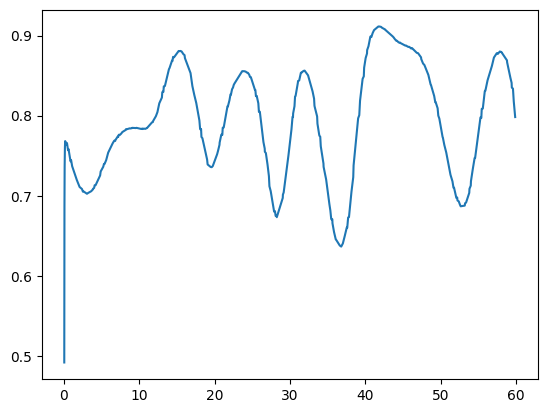

In [33]:
plt.plot(df_empirical_testing['Time'],df_empirical_testing['F_vgt_Pi_t_emp'])